# Imports

In [1]:
import os
import torch
import csv
from tqdm import tqdm
from torch.utils.data import random_split,DataLoader, Subset
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision.models import mobilenet_v3_large
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from collections import Counter

# Transformation and Normalization

In [2]:
data_dir = "/kaggle/input/food41/images"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 101000
    Root location: /kaggle/input/food41/images
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# Count of images in each class

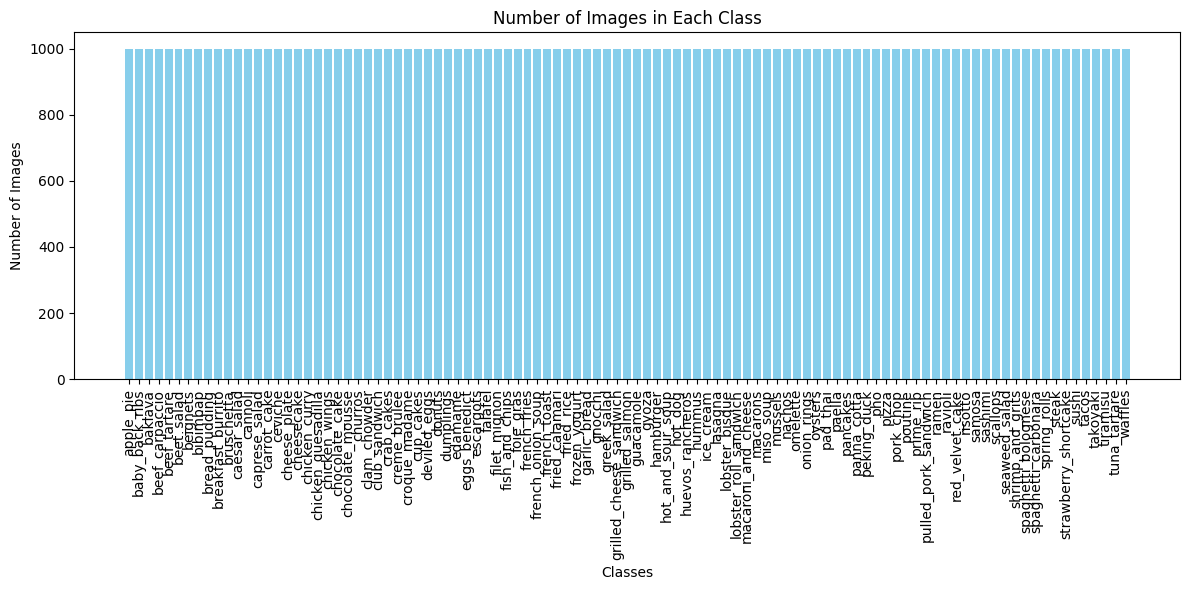

In [3]:
class_counts = Counter([dataset.classes[label] for _, label in dataset.samples])
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("class.png")
plt.show()


# Splitting the Data

In [4]:
indices = list(range(len(dataset)))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=dataset.targets)

In [5]:
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [6]:
val_ratio = 0.5 
val_size = int(len(test_dataset) * val_ratio)
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")

Training images: 80800
Validation images: 10100
Testing images: 10100


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model Training

In [8]:
# model = models.resnet50(pretrained=True)
# model = models.mobilenet_v2(pretrained=True)
model = mobilenet_v3_large(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 185MB/s]


In [9]:
num_classes = len(dataset.classes)

#Resnet
# model.fc = nn.Linear(model.fc.in_features, num_classes)

#Mobilenet
# model.classifier[1] = nn.Linear(model.last_channel, num_classes)

#Mobilenet v3 large
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Adam optimizer

Storing the results in a csv

In [11]:
csv_file = "training_metrics.csv"
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

best_val_loss = float("inf")
best_model_path = "best_model.pth"

In [12]:
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0.0, 0

    # Training phase
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

            pbar.set_postfix(loss=train_loss / len(train_loader))

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)

    # Validation phase
    model.eval()
    val_loss, val_correct = 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)

    with open(csv_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

    print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'model': model,  # The trained model
            'classes': train_dataset.dataset.classes  # Get classes from the original dataset
        }, best_model_path)
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")


Epoch 1/1: 100%|██████████| 632/632 [03:35<00:00,  2.93it/s, loss=4.32] 


Epoch 1/1 -> Train Loss: 4.3235, Train Acc: 0.0918, Val Loss: 3.7402, Val Acc: 0.2375
New best model saved with validation loss: 3.7402


# Loading the model and evaluating on the test set

In [13]:
checkpoint = torch.load("/kaggle/working/best_model.pth", map_location=device)
model = checkpoint['model']  
class_names = checkpoint['classes'] 
model = model.to(device)  
model.eval()  

def evaluate_model(data_loader):
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

test_preds, test_labels = evaluate_model(test_loader)

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

/tmp/ipykernel_30/2122773609.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/best_model.pth", map_location=device)


Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.03      0.01      0.01       107
         baby_back_ribs       0.17      0.11      0.14        90
                baklava       0.22      0.05      0.08        95
         beef_carpaccio       0.12      0.03      0.05       107
           beef_tartare       0.08      0.03      0.04        98
             beet_salad       0.16      0.15      0.15        98
               beignets       0.34      0.49      0.40        93
               bibimbap       0.31      0.25      0.28        85
          bread_pudding       0.00      0.00      0.00        92
      breakfast_burrito       0.15      0.05      0.07       101
             bruschetta       0.11      0.07      0.08        91
           caesar_salad       0.33      0.37      0.35       100
                cannoli       0.15      0.15      0.15       103
          caprese_salad       0.13      0.17      0.15        93
 